In [4]:
import h5py
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
print(tensorflow.__version__)



1.15.2


In [5]:
def define_placeholders(n_x, n_y):    
    # tf functions to use:
    #   tf.placeholder
    #   tf.float32   (wrapper for Dtype float)
    X = tf.placeholder(tf.float32, [n_x, None])
    Y = tf.placeholder(tf.float32, [n_y, None])

    # (2 líneas de código)
    return X, Y

def init_params(layersSizes=[12288, 25, 12, 6]):
#   Returns: Diccionario con los parámetros correspondientes: W1, b1, W2, b2, etc.
    # Funciones a utilizar:
    #   tf.get_variables
    params = {}
    for idx in range(1, len(layersSizes)):
        params[f"W{idx}"] = tf.compat.v1.get_variable(name=f"W{idx}",
                                                    shape=[layersSizes[idx],
                                                    layersSizes[idx-1]],
                                                    initializer=tf.compat.v1.initializers.glorot_normal) 
        params[f"b{idx}"] = tf.compat.v1.get_variable(name=f"b{idx}",
                                                    shape=[layersSizes[idx], 1],
                                                    initializer=tf.compat.v1.initializers.zeros)
    #   tf.contrib.layers.xavier_initializer = tf.compat.v1.initializers.glorot_normal
    #   tf.zeros_initializer = tf.compat.v1.initializers.zeros
    # Documentation https://www.tensorflow.org/api_docs/python/tf/compat/v1/initializers
    # (4 líneas de código)
    return params
    

def forward_pass(X, params):
    # Entradas:
    #    X -- placeholder para datos de entrada con tamaño: (dimensiones, instancias)
    #    params -- diccionario con los parámetros de la red
    # Regresa: 
    #   Z3 -- la salida de la tercera capa >> ANTES << de la función de activación 
    #         porque la función que calcula el costo aplicará la última función de activación.
    # Notas:
    #   La activación para estas capas es ReLU
    
    
    A = tf.cast(X, tf.float32)
    
    for idx in range(1, int(len(params)/2)):        
        Z = tf.add(tf.matmul(params[f"W{idx}"], A), params[f"b{idx}"]) 
        A = tf.nn.relu(Z)
    Z3 = tf.add(tf.matmul(params[f"W{idx+1}"], A), params[f"b{idx+1}"])
    A3 = tf.nn.softmax(Z3)

    # Z1 = tf.add(tf.matmul(params["W1"], tf.cast(X, tf.float32)), params["b1"])
    # A1 = tf.nn.relu(Z1)
    
    # Z2 = tf.add(tf.matmul(params["W2"], A1), params["b2"])
    # A2 = tf.nn.relu(Z2)

    # Z3 = tf.add(tf.matmul(params["W3"], A2), params["b3"])
    # A3 = tf.nn.softmax(Z3)  
        
    # tf.nn.relu(, name=None)
    #   Usar funciones de TF, no de numpy!
    # (aprox. 10 líneas de código)    
    return A3

def compute_cost(Z3, Y):
    # Entradas: 
    #   Z3 -- salida de 'forward_pass'
    #   Y -- es un Placeholder para las etiquetas "verdaderas", con el mismo tamaño que Z3    # 
    # Regresa: 
    #   cost -- el costo    #
    # Funciones a utilizar:
    #   tf.transpose <- importante para que las variables tengan la forma requerida
    #   tf.nn.softmax_cross_entropy_with_logits
    
    # input_tensor = tf.nn.softmax_cross_entropy_with_logits(
    #                         labels=tf.cast(Y, tf.float32), logits=Z3
    #                     )
    input_tensor = tf.nn.softmax_cross_entropy_with_logits_v2(
                            labels=tf.cast(Y, tf.float32), logits=Z3
                        )
    cost = tf.math.reduce_mean(tf.math.reduce_mean(input_tensor=input_tensor))
    #   tf.reduce_mean
    # (3 líneas de código)    
    return cost

def as_OneHot(Y, C=6):        
    # (1 elegante línea de código)
    # return tf.reshape(tf.one_hot(indices=Y, depth=C), shape=(C, -1)) # Pues no es elegante, pero se hizo lo que se pudo.
    
    N = np.zeros((Y.T.size, Y.T.max()+1))
    N[np.arange(Y.T.size),Y.T] = 1
    return N.T

def make_batches(X, Y, batch_size=64, seed=0):
    np.random.seed(seed) # Para tener resultados reproducibles
    # Y.numpy()
    shuffler = np.random.permutation(len(Y.T))

    X = X.T[shuffler]
    X = X.T
    Y = Y.T[shuffler]   
    Y = Y.T


    btch = len(X.T) // batch_size
    batches = []
    for b in range(btch):
        x = X.T[b*batch_size:(b+1)*batch_size]
        y = Y.T[b*batch_size:(b+1)*batch_size]
        batches.append((x.T, y.T))
    
    return batches
    
# def make_batches(X, Y, batch_size=64, seed=0):
#     np.random.seed(seed) # Para tener resultados reproducibles
    
#     # shuffler = np.random.permutation(Y.shape[-1])

#     X = tf.random.shuffle(
#                 value=X.T, seed=seed
#             )
#     X = X.T
#     Y = tf.random.shuffle(
#                 value=Y.T, seed=seed
#             )
#     Y = Y.T


#     btch = X.shape[-1] // batch_size
#     batches = []
#     for b in range(btch):
#         x = X.T[b*batch_size:(b+1)*batch_size]
#         y = Y.T[b*batch_size:(b+1)*batch_size]
#         batches.append((np.array(x.T), np.array(y.T)))
    
#     return batches

# funcion para cargar datos. No necesita modificar esta funcion 
def load_hand_dataset():
    train = h5py.File('/content/drive/MyDrive/MAESTRIA_CIENCIAS_DE_LA_COMPUTACION/SEMESTRE_3/TEMAS_SELECTOS_DEEP_LEARNING/TAREA_8/manos_train.h5',"r")
    X_train = np.array(train["train_set_x"][:]) 
    Y_train = np.array(train["train_set_y"][:]) 
    test = h5py.File('/content/drive/MyDrive/MAESTRIA_CIENCIAS_DE_LA_COMPUTACION/SEMESTRE_3/TEMAS_SELECTOS_DEEP_LEARNING/TAREA_8/manos_test.h5',"r")
    X_test = np.array(test["test_set_x"][:])
    Y_test = np.array(test["test_set_y"][:])
    classes = np.array(test["list_classes"][:])    
    Y_train = Y_train.reshape((1, Y_train.shape[0]))
    Y_test = Y_test.reshape((1, Y_test.shape[0]))
    X_train_flat = X_train.reshape(X_train.shape[0], -1).T
    X_test_flat = X_test.reshape(X_test.shape[0], -1).T    
    X_train = X_train_flat/255.
    X_test = X_test_flat/255.
    d = {"X_train": X_train,
         "Y_train": Y_train, 
         "X_test" : X_test, 
         "Y_test" : Y_test, 
         "classes" : classes}
    return d

# d = load_hand_dataset()
# X_train = d['X_train']
# X_test = d['X_test']
# Y_train = d['Y_train']
# Y_test = d['Y_test']
# train_Y = as_OneHot(Y=Y_train)
# params = init_params()
# A3 = forward_pass(X=X_train, params=params)
# # tf.compat.v1.reset_default_graph()
# init = tf.compat.v1.global_variables_initializer()
# cost = compute_cost(Z3=A3, Y=train_Y)
# with tf.compat.v1.Session() as sess:
#     sess.run(init)
#     c = sess.run(cost)
#     print(c)
    
    


Costo en epoca 0: 110.903614
Costo en epoca 100: 110.903557
Costo en epoca 200: 110.903557
Costo en epoca 300: 110.903557
Costo en epoca 400: 110.903557
Costo en epoca 500: 110.903557
Costo en epoca 600: 110.903557
Costo en epoca 700: 110.903557
Costo en epoca 800: 110.903557
Costo en epoca 900: 110.903557
Costo en epoca 1000: 110.903557
Costo en epoca 1100: 110.903557
Costo en epoca 1200: 110.903557
Costo en epoca 1300: 110.903557
Costo en epoca 1400: 110.903557


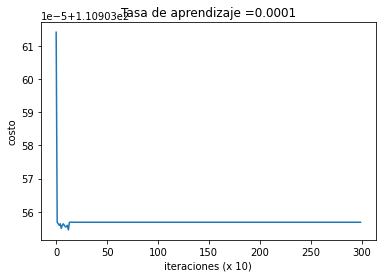

Accuracy de entrenamiento: 1.0
Accuracy de prueba: 1.0


In [ ]:


# Definir la red. No es necesario modificar esta función EXCEPTO para completar la línea de Backpropagation
# Ya conocemos lo que hacen todos estos parámetros, simplemente lo estamos implementando con TF    
data_set = load_hand_dataset()
def model(X_train, Y_train, X_test, Y_test, layers_sizes, eta = 0.0001, N = 1500, batch_size = 32):        
    ops.reset_default_graph()                         # esto es para resetear el modelo
    (X_dims, m) = X_train.shape                       # X_dims: dimensiones de nuestro problema
    Y_dims = Y_train.shape[0]                         # Y_dims: dimensiones de Y (y tamaño de la salida)    
    costs = []                                        
    
    # 1) Crear Placeholders de tamaños [X_dims, None] y [Y_dims, None]    
    #       Usamos 'None' para dejar abierto el número de instancias,
    #       que de hecho van a cambiar en el entrenamiento y prueba
    X, Y = define_placeholders(X_dims, Y_dims) 
        
    # 2) Inicializa parámetros (pesos W_l y biases b_l)
    params = init_params(layers_sizes)     
    
    # 3a) Definir Forward propagation y cálculo del costo     
    Z3 = forward_pass(X, params)

    cost = compute_cost(Z3, Y)  # Función de costo (no se ha ejecutado, solo se define)
      
    # 3b) Definir el optimizador para backpropagation
    # ---> Backpropagation: debemos definir un optimizador (se ejecuta despues). Usaremos Adam:    
    optimizer = tf.train.AdamOptimizer(learning_rate = eta).minimize(cost)   # <-- IMPORTANTE: COMPLETAR ESTA LÍNEA
            
    init = tf.global_variables_initializer() # Inicializa variables
    
    # 4) Iniciamos la sesión 
    with tf.Session() as sess:       
        seed = 3  # para remuestreo de (mini)lotes
        
        # Inicializamos las variables de la sesión
        sess.run(init)        
        # Ciclo de entrenamiento
        for epoch in range(N):  
            epoch_cost = 0.                       # Costo por epoca
            num_batches = int(m / batch_size)     # número de (mini)lotes
            seed = seed + 1                       # para remuestreo de (mini)lotes
            batches = make_batches(X_train, Y_train, batch_size, seed)  # <-- ocupa su funcion 'make_batches'

            for batch in batches:
                (batch_X, batch_Y) = batch      # Toma un (mini)lote                

                # 5) Ejecutamos los pasos definidos arriba como "optimizer" y "cost"
                #   el diccionario de entrada debe de ser un (mini)lote para X y Y.                
                _ , batch_cost = sess.run([optimizer, cost], feed_dict={X: batch_X, Y: batch_Y})                                
                
                # Acumulamos el costo por época (al final será el promedio):
                epoch_cost += batch_cost / num_batches

            # Reportar y guardar costo
            if epoch % 100 == 0: print ("Costo en epoca %i: %f" % (epoch, epoch_cost))
            if epoch % 5 == 0: costs.append(epoch_cost)
                
        # Graficar el costo
        plt.plot(np.squeeze(costs))
        plt.ylabel('costo')
        plt.xlabel('iteraciones (x 10)')
        plt.title("Tasa de aprendizaje =" + str(eta))
        plt.show()
                
        # 6) Rescatar los parámetros ajustados, para regresarlos
        params = sess.run(params)  
        
        # Desplegar resultados de accuracy
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))   # Calcular aciertos
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))  # Accuracy
        print ("Accuracy de entrenamiento:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Accuracy de prueba:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return params

    
# --- MAIN (No es necesario modificar) ---
# Cargar dataset
mydata = load_hand_dataset()   
train_X = mydata["X_train"][:]
test_X = mydata["X_test"][:]
Y_train = mydata["Y_train"][:]
Y_test = mydata["Y_test"][:]
classes = mydata["classes"][:]

# Convertir las etiquetas a codificación "one hot"
train_Y = as_OneHot(Y_train, len(classes))
test_Y = as_OneHot(Y_test, len(classes))
# Definir la arquitectura (capas ocultas = ReLU, capa de salida = SoftMax)
layers_sizes = [12288, 25, 12, 6]
params = model(train_X, train_Y, test_X, test_Y, layers_sizes)

